In [1]:
# # keras model 
# from keras.models import Sequential
# from keras.layers.core import Dense, Dropout, Activation
# from keras.optimizers import SGD

from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

# sklearn model
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn import tree
from sklearn.tree.export import export_text

from nilmtk import DataSet
from nilmtk.utils import print_dict


import graphviz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import warnings

rcParams['figure.figsize'] = (8, 5)
rcParams['figure.dpi'] = 150

import seaborn as sns
color_palette = sns.color_palette("muted")
sns.set_palette(color_palette)
sns.set_style("whitegrid")
sns.set_context("paper", font_scale=1.10, rc={"lines.linewidth": 1.5, "figure.figsize":(8, 4.5), "figure.dpi": 150})

warnings.filterwarnings('ignore')

Using TensorFlow backend.
c:\users\chuan\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\users\chuan\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\users\chuan\appdata\local\programs\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16

In [2]:
ampd = DataSet("./AMPD/AMPds.h5")

# setting start and end dates
start_date = "2012-04-01"
end_date = "2012-04-07"

ampd.set_window(start=start_date, end=end_date)
bdn1 = ampd.buildings[1]

elec = bdn1.elec

In [3]:
def convert_to_df(elec, export_unknown=False):
    df_list = []
    for i in range(2, 22):
        appliance = elec[i]
        appliance_name = appliance.appliances[0].identifier.type
        appliance_id = appliance.appliances[0].identifier.instance
        
        if export_unknown == True: 
            if appliance_name != 'unknown':
                continue
        else:
            if appliance_name == 'unknown':
                continue
        
        appliance_name = f"{appliance_name} {appliance_id}"
        print(f"{i} \t {appliance_name}")
        
        df = next(elec[i].load())
        active = np.array(df['power']['active'])
        reactive = np.array(df['power']['reactive'])
        pf = np.array(df['power factor']['apparent'])
        
        df = pd.DataFrame({
            "active": active,
            "reactive": reactive,
            "pf": pf,
            "appliance": appliance_name
        })
        
        df_list.append(df)
        
    return pd.concat(df_list).drop_duplicates()

In [4]:
df = convert_to_df(elec, export_unknown=False)
udf = convert_to_df(elec, export_unknown=True)

2 	 light 1
3 	 light 2
4 	 light 3
7 	 sockets 1
11 	 fridge 1
14 	 heat pump 1
16 	 light 4
17 	 sockets 2
19 	 television 1
20 	 sockets 3
21 	 electric oven 1
5 	 unknown 1
6 	 unknown 2
8 	 unknown 3
9 	 unknown 4
10 	 unknown 5
12 	 unknown 6
13 	 unknown 7
15 	 unknown 8
18 	 unknown 9


In [5]:
df_x = df[['active', 'reactive', 'pf']]
df_y = df['appliance']
# encode y to integer
encoder = LabelEncoder()
encoded_y = encoder.fit(df_y).transform(df_y)
onehot_y = np_utils.to_categorical(encoded_y)

In [6]:
clf = tree.DecisionTreeClassifier()
clf.fit(df_x, df_y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [7]:
clf.score(df_x, df_y)

0.9947643979057592

In [20]:
r = export_text(clf, feature_names=df.columns[:-1].to_list())
print(r)

|--- reactive <= 180.00
|   |--- reactive <= 29.50
|   |   |--- reactive <= 11.50
|   |   |   |--- active <= 52.00
|   |   |   |   |--- reactive <= 5.50
|   |   |   |   |   |--- pf <= 0.68
|   |   |   |   |   |   |--- pf <= 0.23
|   |   |   |   |   |   |   |--- reactive <= 3.00
|   |   |   |   |   |   |   |   |--- reactive <= 0.50
|   |   |   |   |   |   |   |   |   |--- active <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- pf <= 0.07
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |   |--- pf >  0.07
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 3
|   |   |   |   |   |   |   |   |   |--- active >  0.50
|   |   |   |   |   |   |   |   |   |   |--- class: light 1
|   |   |   |   |   |   |   |   |--- reactive >  0.50
|   |   |   |   |   |   |   |   |   |--- pf <= 0.05
|   |   |   |   |   |   |   |   |   |   |--- class: electric oven 1
|   |   |   |   |   |   |   |   |   |--- pf >  0.05
|  

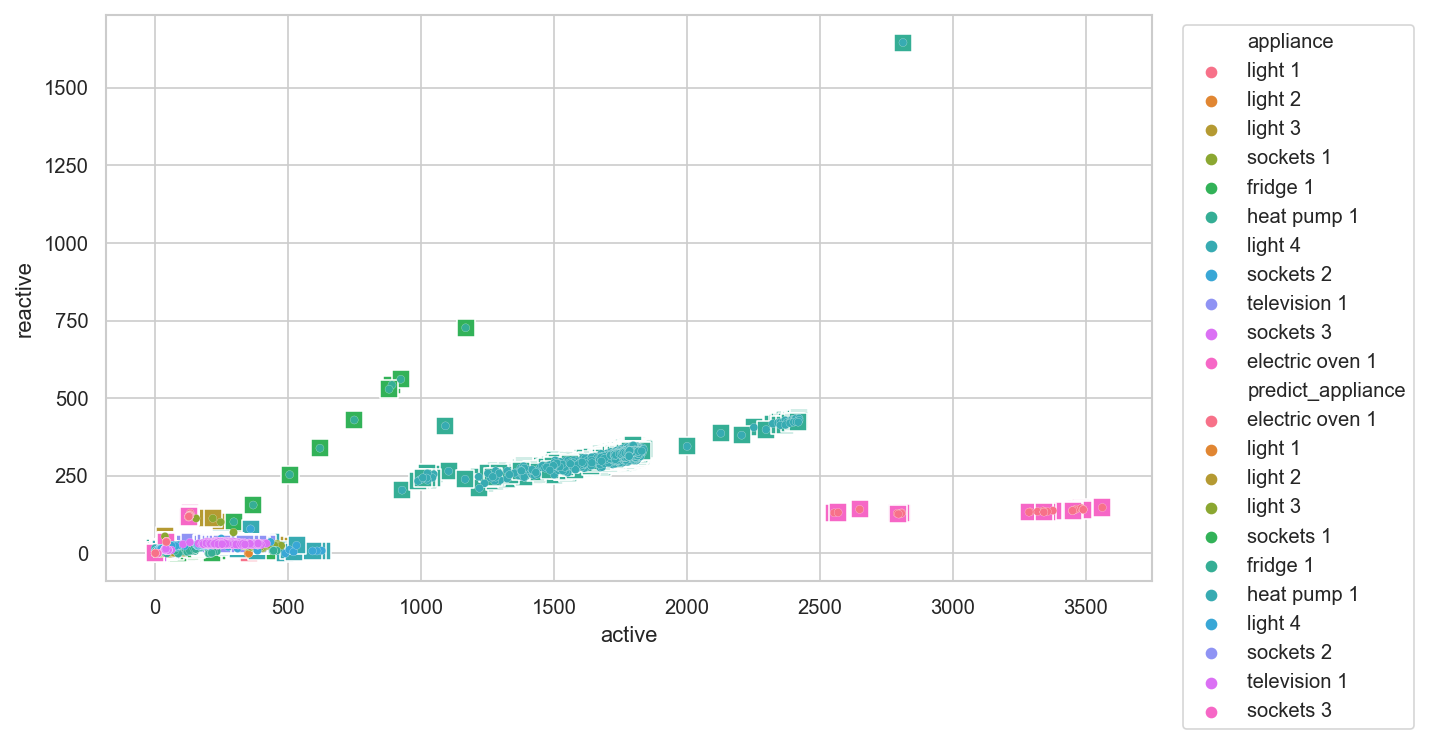

In [22]:
fig = plt.figure(figsize=(9, 5), dpi=150)
sns.scatterplot(x='active', y='reactive', data=df, hue='appliance', marker='s', s=75)
df['predict_appliance'] = clf.predict(df_x)
sns.scatterplot(x='active', y='reactive', data=df, hue='predict_appliance', s=15, linewidth=0.1)
plt.legend(bbox_to_anchor=(1.02, 1), loc=2)

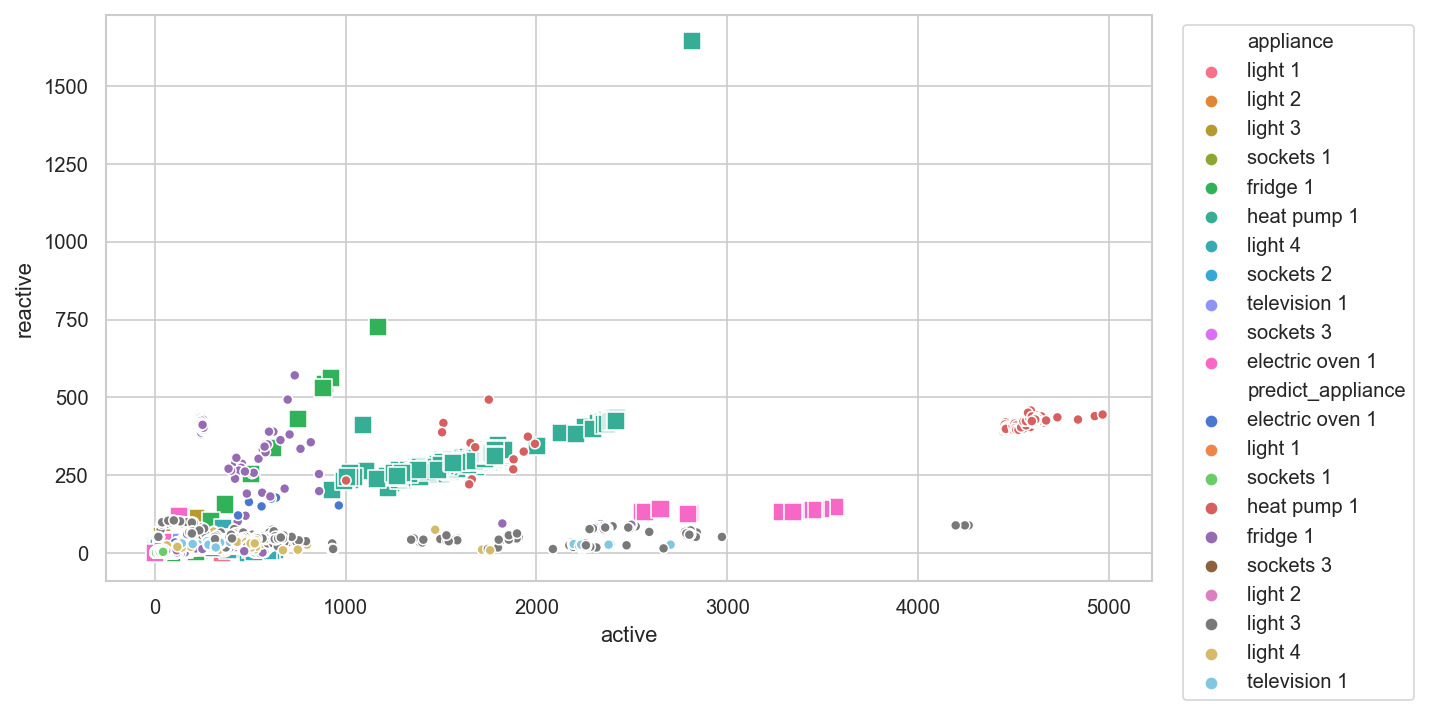

In [23]:
udf_x = udf[['active', 'reactive', 'pf']]
udf_y = udf['appliance']


fig = plt.figure(figsize=(9, 5), dpi=150)
sns.scatterplot(x='active', y='reactive', data=df, hue='appliance', marker='s', s=75)

udf['predict_appliance'] = clf.predict(udf_x)

sns.scatterplot(x='active', y='reactive', data=udf, hue='predict_appliance')
plt.legend(bbox_to_anchor=(1.02, 1), loc=2)